# Numerical Variables Analysis

We will be examining the numerical variables of the `kaggle_steam` dataset (available in `data/01_raw/kaggle_steam.csv`) in this notebook.

After analysis, we will propose numerical features to adopt for our clustering model, KPrototypes.

The dataset has **6** numerical variables: `achievements`, `positive_ratings`, `negative_ratings`, `average_playtime`, `median_playtime`,`price`.

We will be using PCA to analyse them.

**Setting up**

In [1]:
%load_ext kedro.ipython
%load_ext autoreload
%matplotlib inline
%autoreload 2

[04/18/23 01:06:09] INFO     Resolved project path as: /home/eckt/Documents/usg.                    ]8;id=33762;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=127774;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[04/18/23 01:06:11] INFO     Kedro project usg                                                      ]8;id=523339;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=969915;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=876734;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=106207;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

[04/18/23 01:06:13] INFO     Registered line magic 'run_viz'                                        ]8;id=114964;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=68013;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py#110\110]8;;\

In [46]:
import pandas as pd
import polars as pl
import numpy as np

from matplotlib import rc_context
import matplotlib.pyplot as plt
import seaborn as sb
from seaborn.objects import Plot
import seaborn.objects as so

from sklearn.preprocessing import maxabs_scale, scale, power_transform, PowerTransformer
from sklearn.decomposition import PCA

import logging

from usg.utils import *

log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
sb.set()

**All features of `kaggle_steam` and their dtypes**

The dataset has **6** numerical variables: `achievements`, `positive_ratings`, `negative_ratings`, `average_playtime`, `median_playtime` and `price`.

In [3]:
kaggle_steam: pd.DataFrame = catalog.load('kaggle_steam')
kaggle_steam.dtypes.to_frame().T

[04/18/23 01:06:14] INFO     Loading data from 'kaggle_steam' (CSVDataSet)...                   ]8;id=739406;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=198726;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#343\343]8;;\

appid    name release_date english developer publisher platforms  \
0  int64  object       object   int64    object    object    object   

  required_age categories  genres steamspy_tags achievements positive_ratings  \
0        int64     object  object        object        int64            int64   

  negative_ratings average_playtime median_playtime  owners    price  
0            int64            int64           int64  object  float64

In [4]:
def lim_quantile(data: pd.Series, quantile: float = 0.95):
    return data <= data.quantile(quantile)

In [5]:
def hist_skew(data: pd.Series, quantile: float = 0.95, reverse=False, ax=None, **opts):
    p = lim_quantile(data, quantile)
    dir = '<='
    if reverse:
        p = ~p
        dir = '>'
    return sb.histplot(data[p], kde=True, ax=ax).set(title=f'{dir}{quantile} quantile (skew={float(data.skew()):.2f})', **opts)

In [6]:
def power_transform1(data: pd.Series,**kwargs):
    return pd.DataFrame(power_transform(data.to_frame(), **kwargs), columns=[data.name]).iloc[:,0]

In [7]:
def viz_transform(data: pd.Series, q1=0.95, q2=0.95):
    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12,6))
    fig.set_tight_layout(True)
    hist_skew(data, quantile=q1, ax=ax[0][0], yscale='log')
    hist_skew(data, quantile=q2, ax=ax[0][1], reverse=True)
    p = power_transform1(data, standardize=False)
    sb.histplot(p, ax=ax[0][2], kde=True).set(title=f'after power transform (skew={float(p.skew()):.2f})')
    sb.boxplot(data, orient='h', ax=ax[1][0]).set(title=f'before power transform (skew={float(data.skew()):.2f})')
    sb.boxplot(p, orient='h', ax=ax[1][1]).set(title=f'after power transform (skew={float(p.skew()):.2f})')
    sb.violinplot(p, orient='h', ax=ax[1][2]).set(title=f'after power transform (skew={float(p.skew()):.2f})')

# Introduction

All of our numeric variables are unfortunately very very skewed. This makes it hard to visualise and work with the data. Furthermore, high skewness can greatly affect the euclidean metric for clustering. 

Hence, we decided on `power transform`ing our data which can reduce skewness.

In [8]:
columns = ['achievements', 'positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 'price']

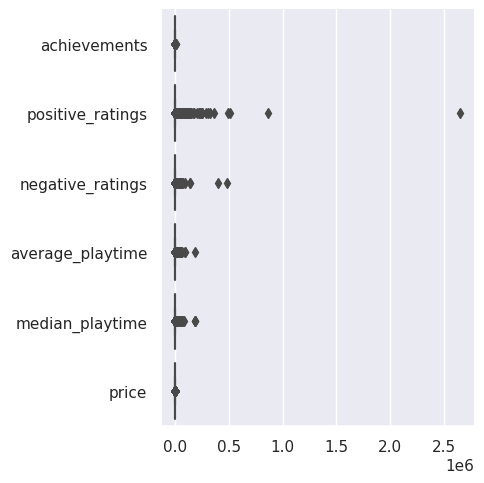

In [9]:
sb.catplot(data=kaggle_steam[columns], orient='h', kind='box')

## [numerical/1] `achievements`

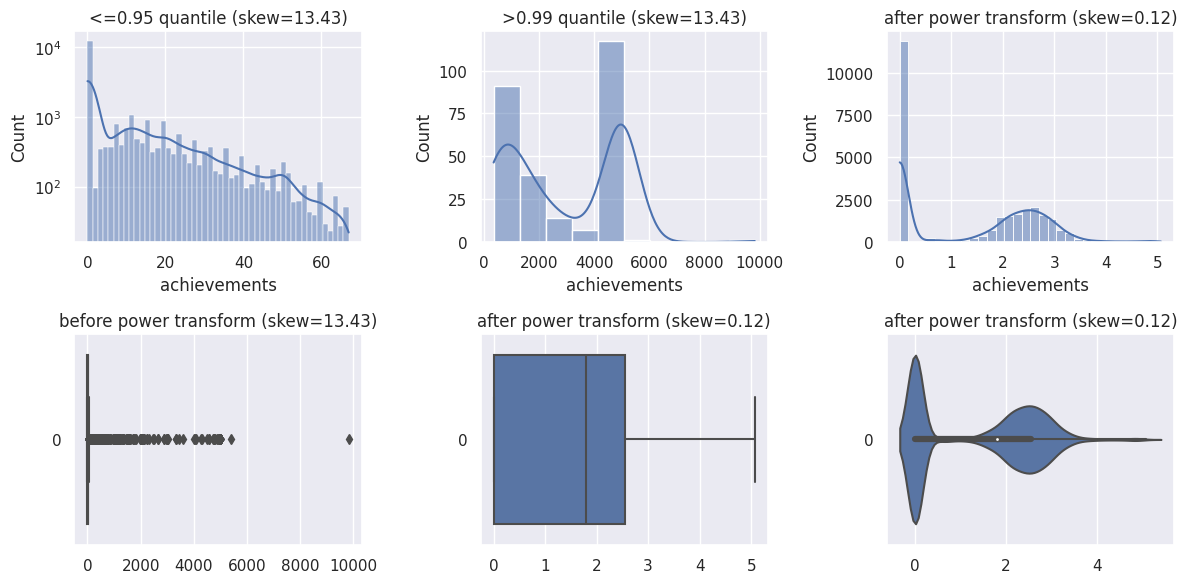

In [10]:
viz_transform(kaggle_steam['achievements'], q2=0.99)

## [numerical/2] `positive_ratings`

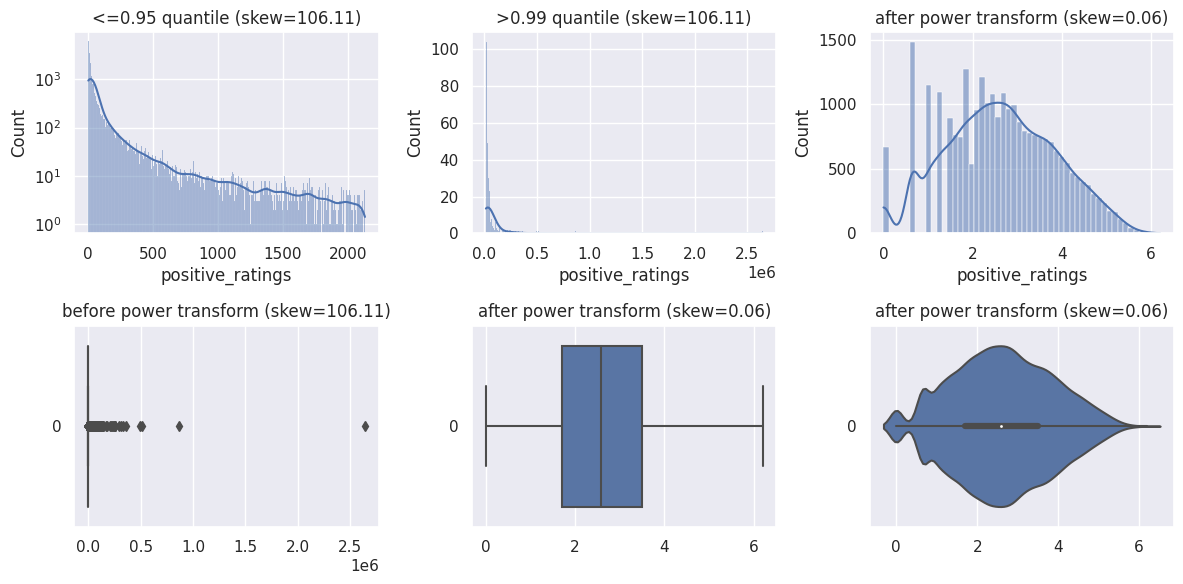

In [11]:
viz_transform(kaggle_steam['positive_ratings'], q2=.99)

## [numerical/3] `negative_ratings`

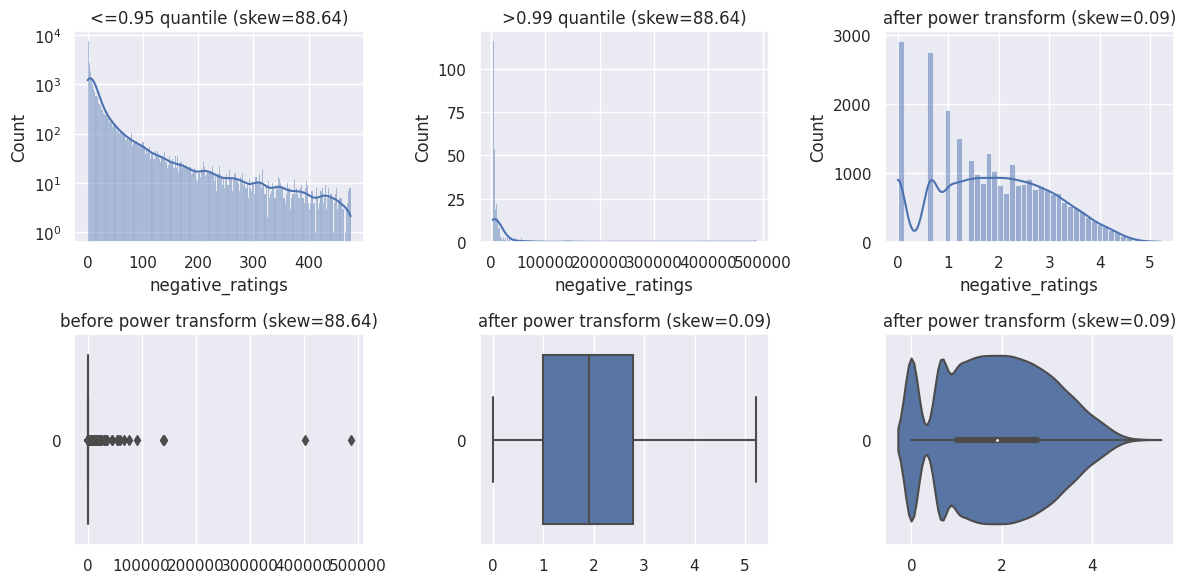

In [12]:
viz_transform(kaggle_steam['negative_ratings'], q2=.99)

## [numerical/4] `average_playtime`

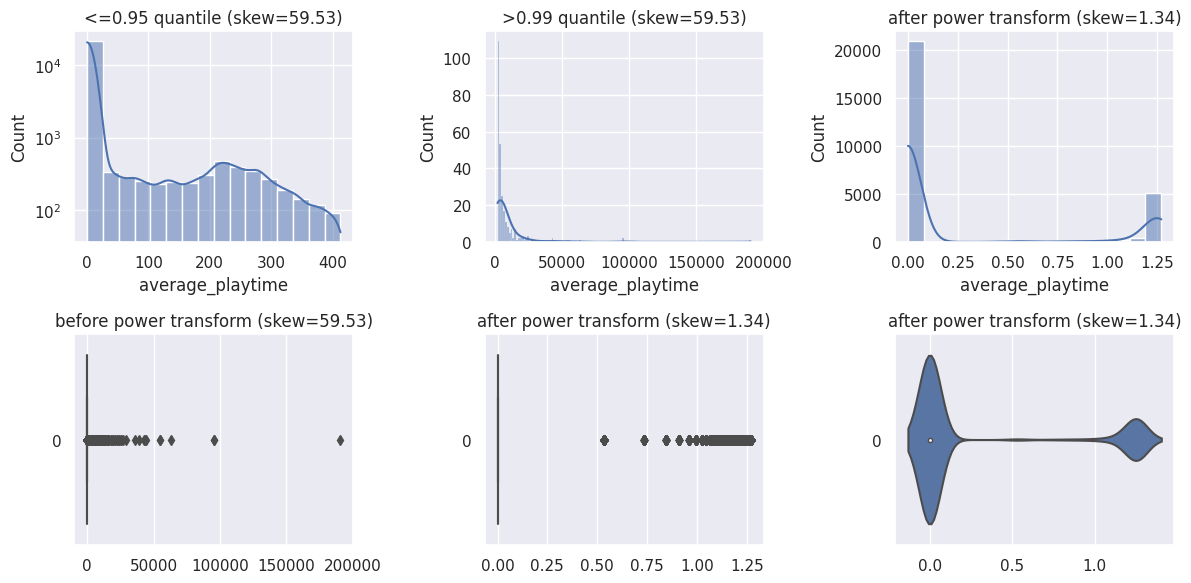

In [13]:
viz_transform(kaggle_steam['average_playtime'], q2=.99)

## [numerical/5] `median_playtime`

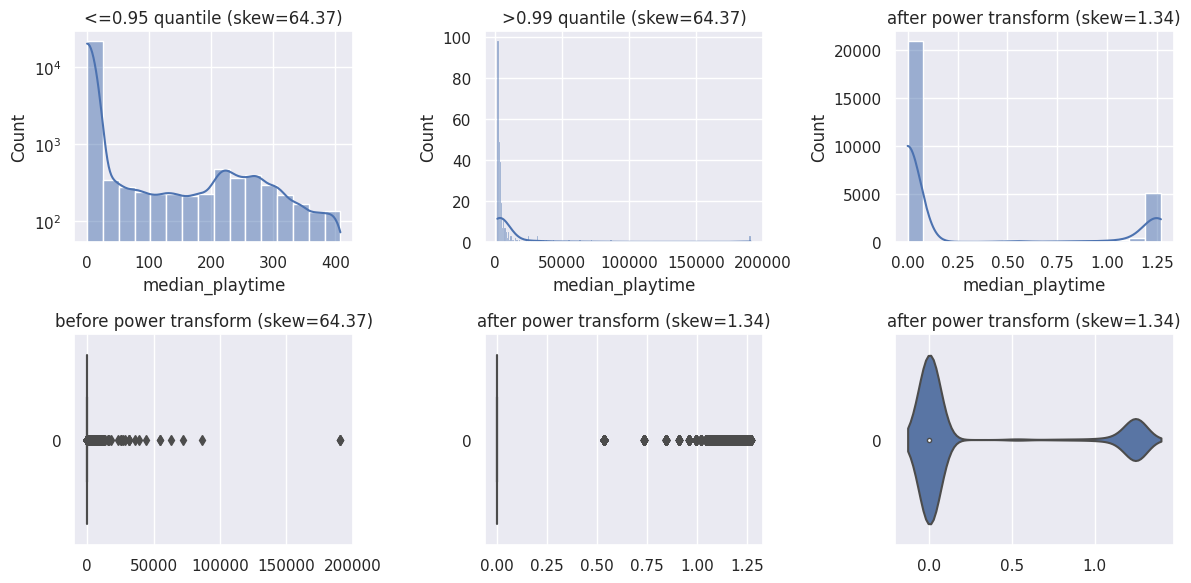

In [14]:
viz_transform(kaggle_steam['median_playtime'], q2=.99)

## [numerical/6] `price`

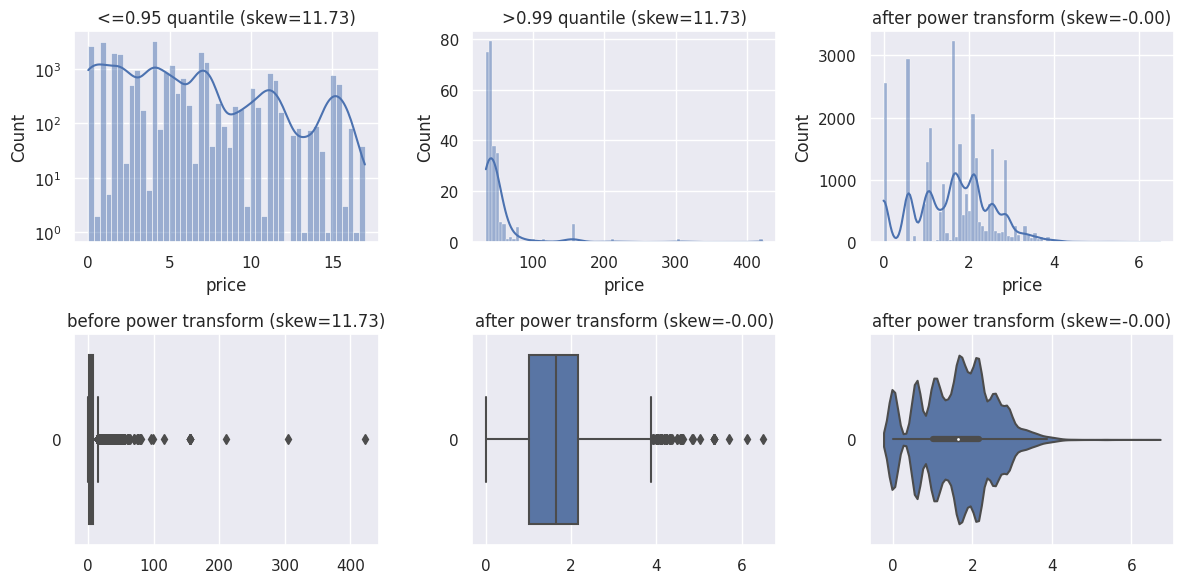

In [15]:
viz_transform(kaggle_steam['price'], q2=.99)

# Feature engineering

We add a new column, `ratings_ratio`

In [56]:
ratings_ratio = kaggle_steam['positive_ratings'] / kaggle_steam['negative_ratings']
ratings_ratio.loc[np.isinf(ratings_ratio)] = 0
ratings_ratio = ratings_ratio.rename('ratings_ratio')
kaggle_steam['ratings_ratio'] = ratings_ratio

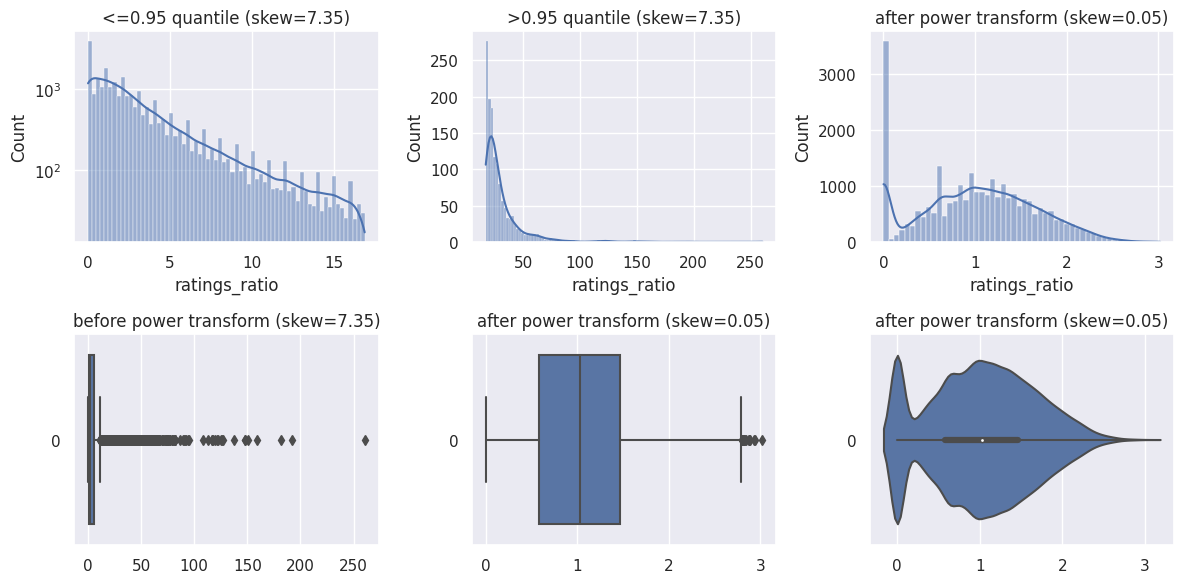

In [55]:
viz_transform(ratings_ratio)

# Correlation analysis

`positive_ratings` and `negative_ratings` show high correlation.

`average_playtime` and `median_playtime` shows extremely high correlation.

In [57]:
columns = ['achievements', 'positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 'price', 'ratings_ratio']

[Text(0.5, 1.0, 'Correlation between numeric features')]

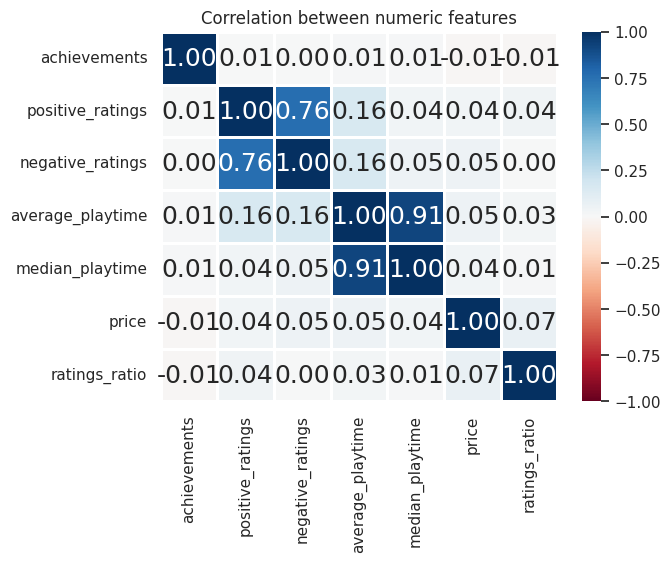

In [58]:
sb.heatmap(kaggle_steam[columns].corr(), vmin=-1, vmax=1, linewidths=1, annot=True, fmt=".2f", annot_kws={'size': 18}, cmap='RdBu').set(title='Correlation between numeric features')

[Text(0.5, 1.0, 'Correlation between average_playtime, mean_playtime w/o outliers')]

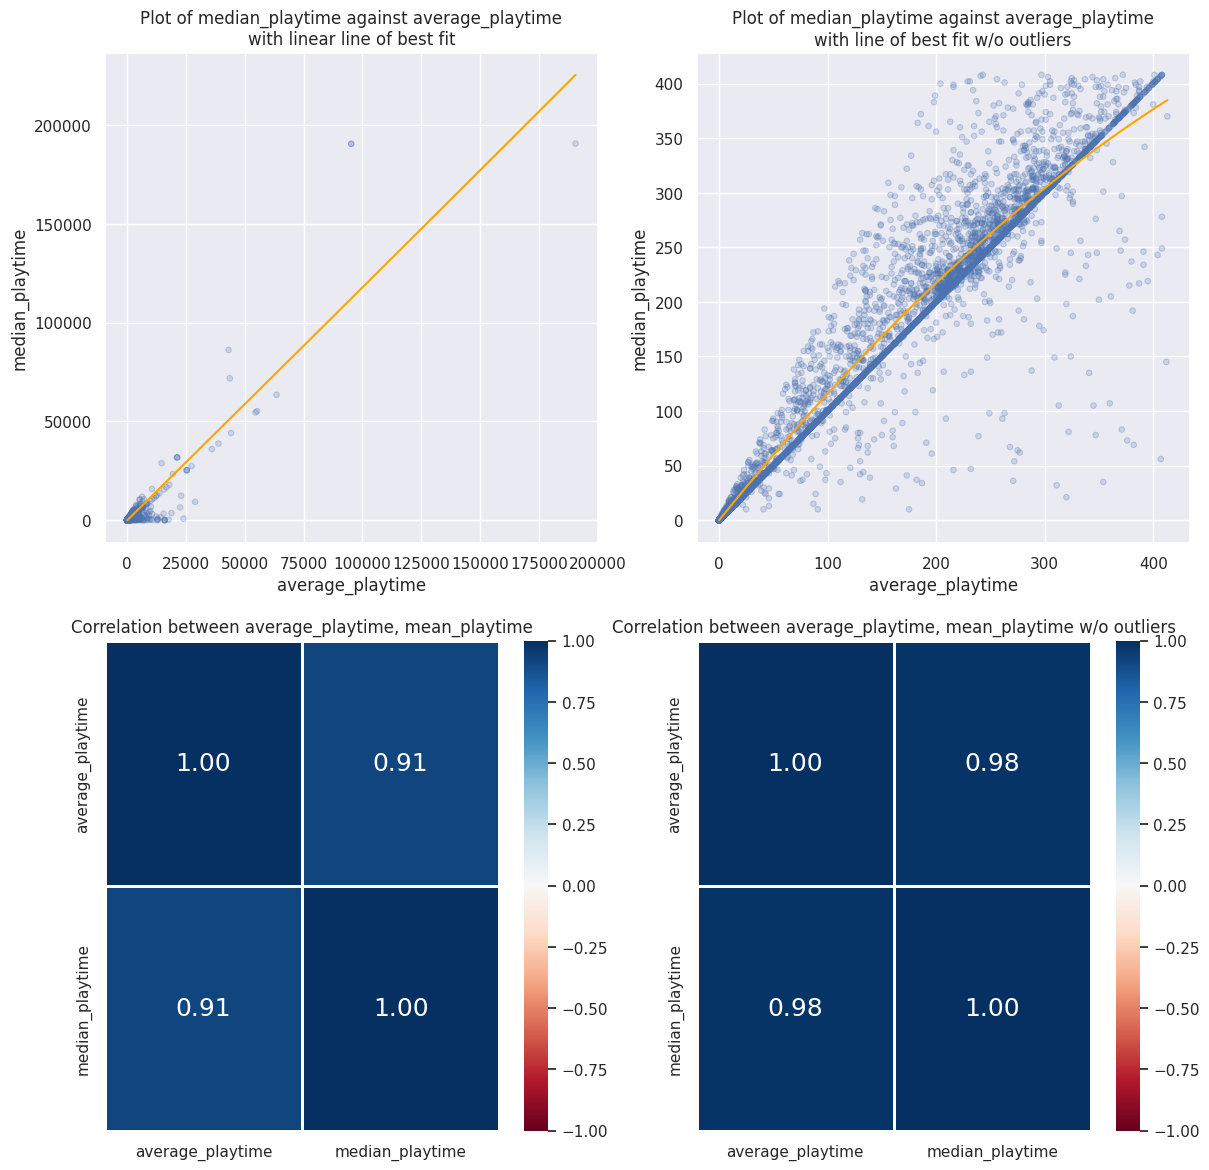

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
fig.set_tight_layout(True)
(
    Plot(
        data=kaggle_steam,
        x='average_playtime', 
        y='median_playtime'
    )
    .add(so.Dots(alpha=.3))
    .add(so.Line(color='orange'), so.PolyFit())
    .label(title='Plot of median_playtime against average_playtime\nwith linear line of best fit')
    .on(ax[0][0])
    .plot()
)
(
    Plot(
        data=kaggle_steam.loc[
            lim_quantile(kaggle_steam['average_playtime']) & lim_quantile(kaggle_steam['median_playtime'])
        ], 
        x='average_playtime', 
        y='median_playtime'
    )
    .add(so.Dots(alpha=.3))
    .add(so.Line(color='orange'), so.PolyFit())
    .label(title='Plot of median_playtime against average_playtime\nwith line of best fit w/o outliers')
    .on(ax[0][1])
    .plot()
)
sb.heatmap(data=kaggle_steam.loc[
            :, 
            ['average_playtime', 'median_playtime']
        ].corr(), 
        vmin=-1, vmax=1, linewidths=1, annot=True, fmt=".2f", annot_kws={'size': 18}, cmap='RdBu',
        ax=ax[1][0]
).set(title='Correlation between average_playtime, mean_playtime')
sb.heatmap(data=kaggle_steam.loc[
            lim_quantile(kaggle_steam['average_playtime']) & lim_quantile(kaggle_steam['median_playtime']), 
            ['average_playtime', 'median_playtime']
        ].corr(), 
        vmin=-1, vmax=1, linewidths=1, annot=True, fmt=".2f", annot_kws={'size': 18}, cmap='RdBu',
        ax=ax[1][1]
).set(title='Correlation between average_playtime, mean_playtime w/o outliers')

[Text(0.5, 1.0, 'Correlation between positive_ratings, negative_ratings w/o outliers')]

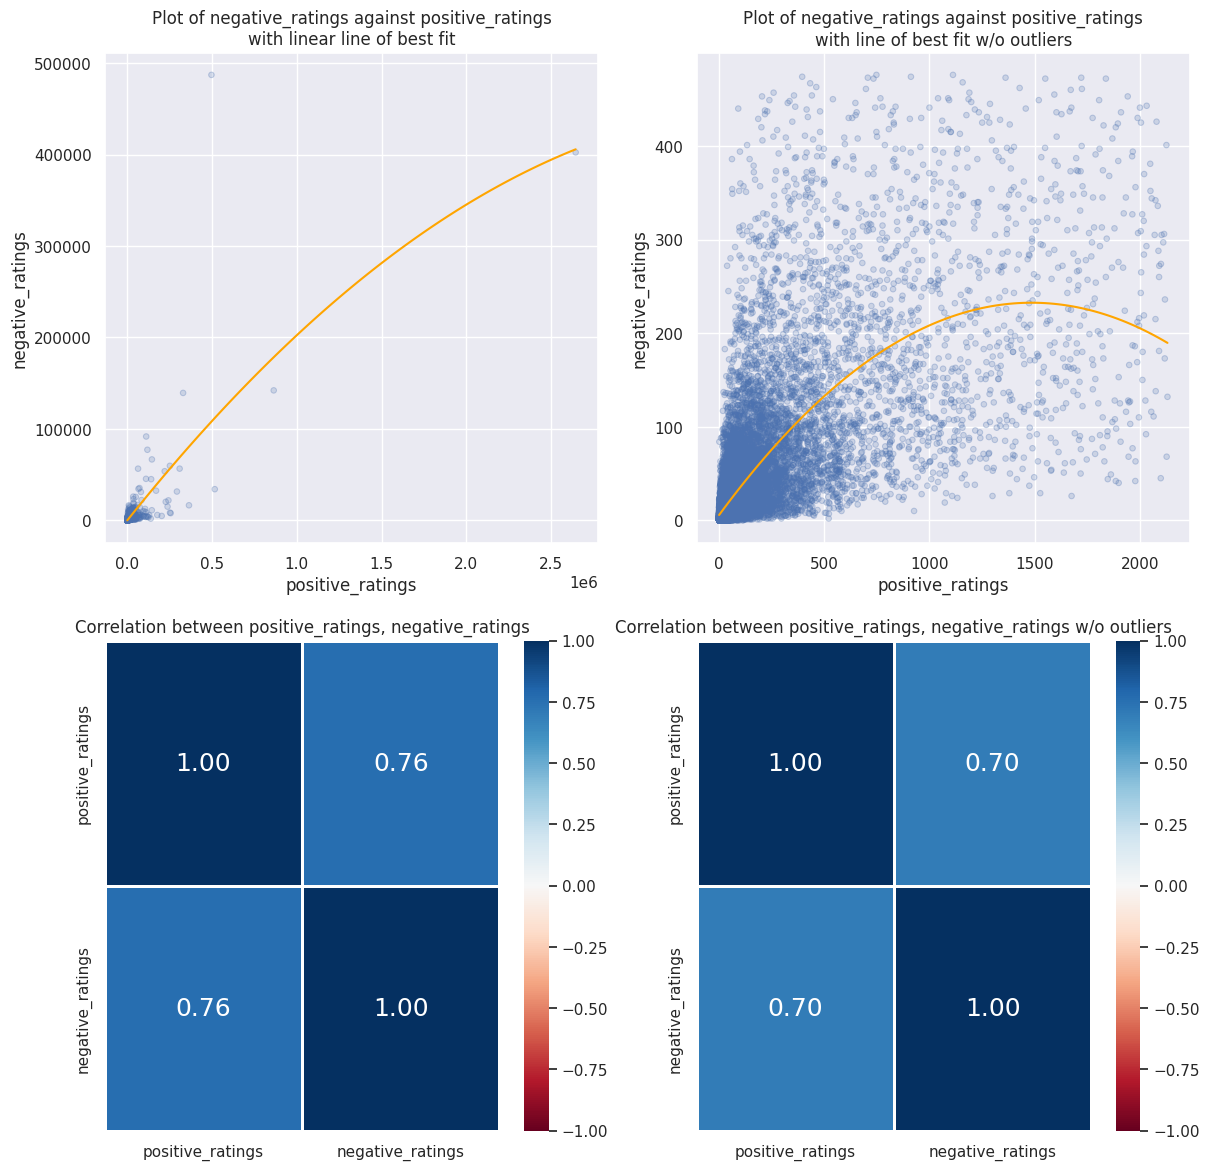

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
fig.set_tight_layout(True)
(
    Plot(
        data=kaggle_steam,
        x='positive_ratings', 
        y='negative_ratings'
    )
    .add(so.Dots(alpha=.3))
    .add(so.Line(color='orange'), so.PolyFit())
    .label(title='Plot of negative_ratings against positive_ratings\nwith linear line of best fit')
    .on(ax[0][0])
    .plot()
)
(
    Plot(
        data=kaggle_steam.loc[
            lim_quantile(kaggle_steam['positive_ratings']) & lim_quantile(kaggle_steam['negative_ratings'])
        ], 
        x='positive_ratings', 
        y='negative_ratings'
    )
    .add(so.Dots(alpha=.3))
    .add(so.Line(color='orange'), so.PolyFit())
    .label(title='Plot of negative_ratings against positive_ratings\nwith line of best fit w/o outliers')
    .on(ax[0][1])
    .plot()
)
sb.heatmap(data=kaggle_steam.loc[
            :, 
            ['positive_ratings', 'negative_ratings']
        ].corr(), 
        vmin=-1, vmax=1, linewidths=1, annot=True, fmt=".2f", annot_kws={'size': 18}, cmap='RdBu',
        ax=ax[1][0]
).set(title='Correlation between positive_ratings, negative_ratings')
sb.heatmap(data=kaggle_steam.loc[
            lim_quantile(kaggle_steam['positive_ratings']) & lim_quantile(kaggle_steam['negative_ratings']), 
            ['positive_ratings', 'negative_ratings']
        ].corr(), 
        vmin=-1, vmax=1, linewidths=1, annot=True, fmt=".2f", annot_kws={'size': 18}, cmap='RdBu',
        ax=ax[1][1]
).set(title='Correlation between positive_ratings, negative_ratings w/o outliers')

# Pairplot

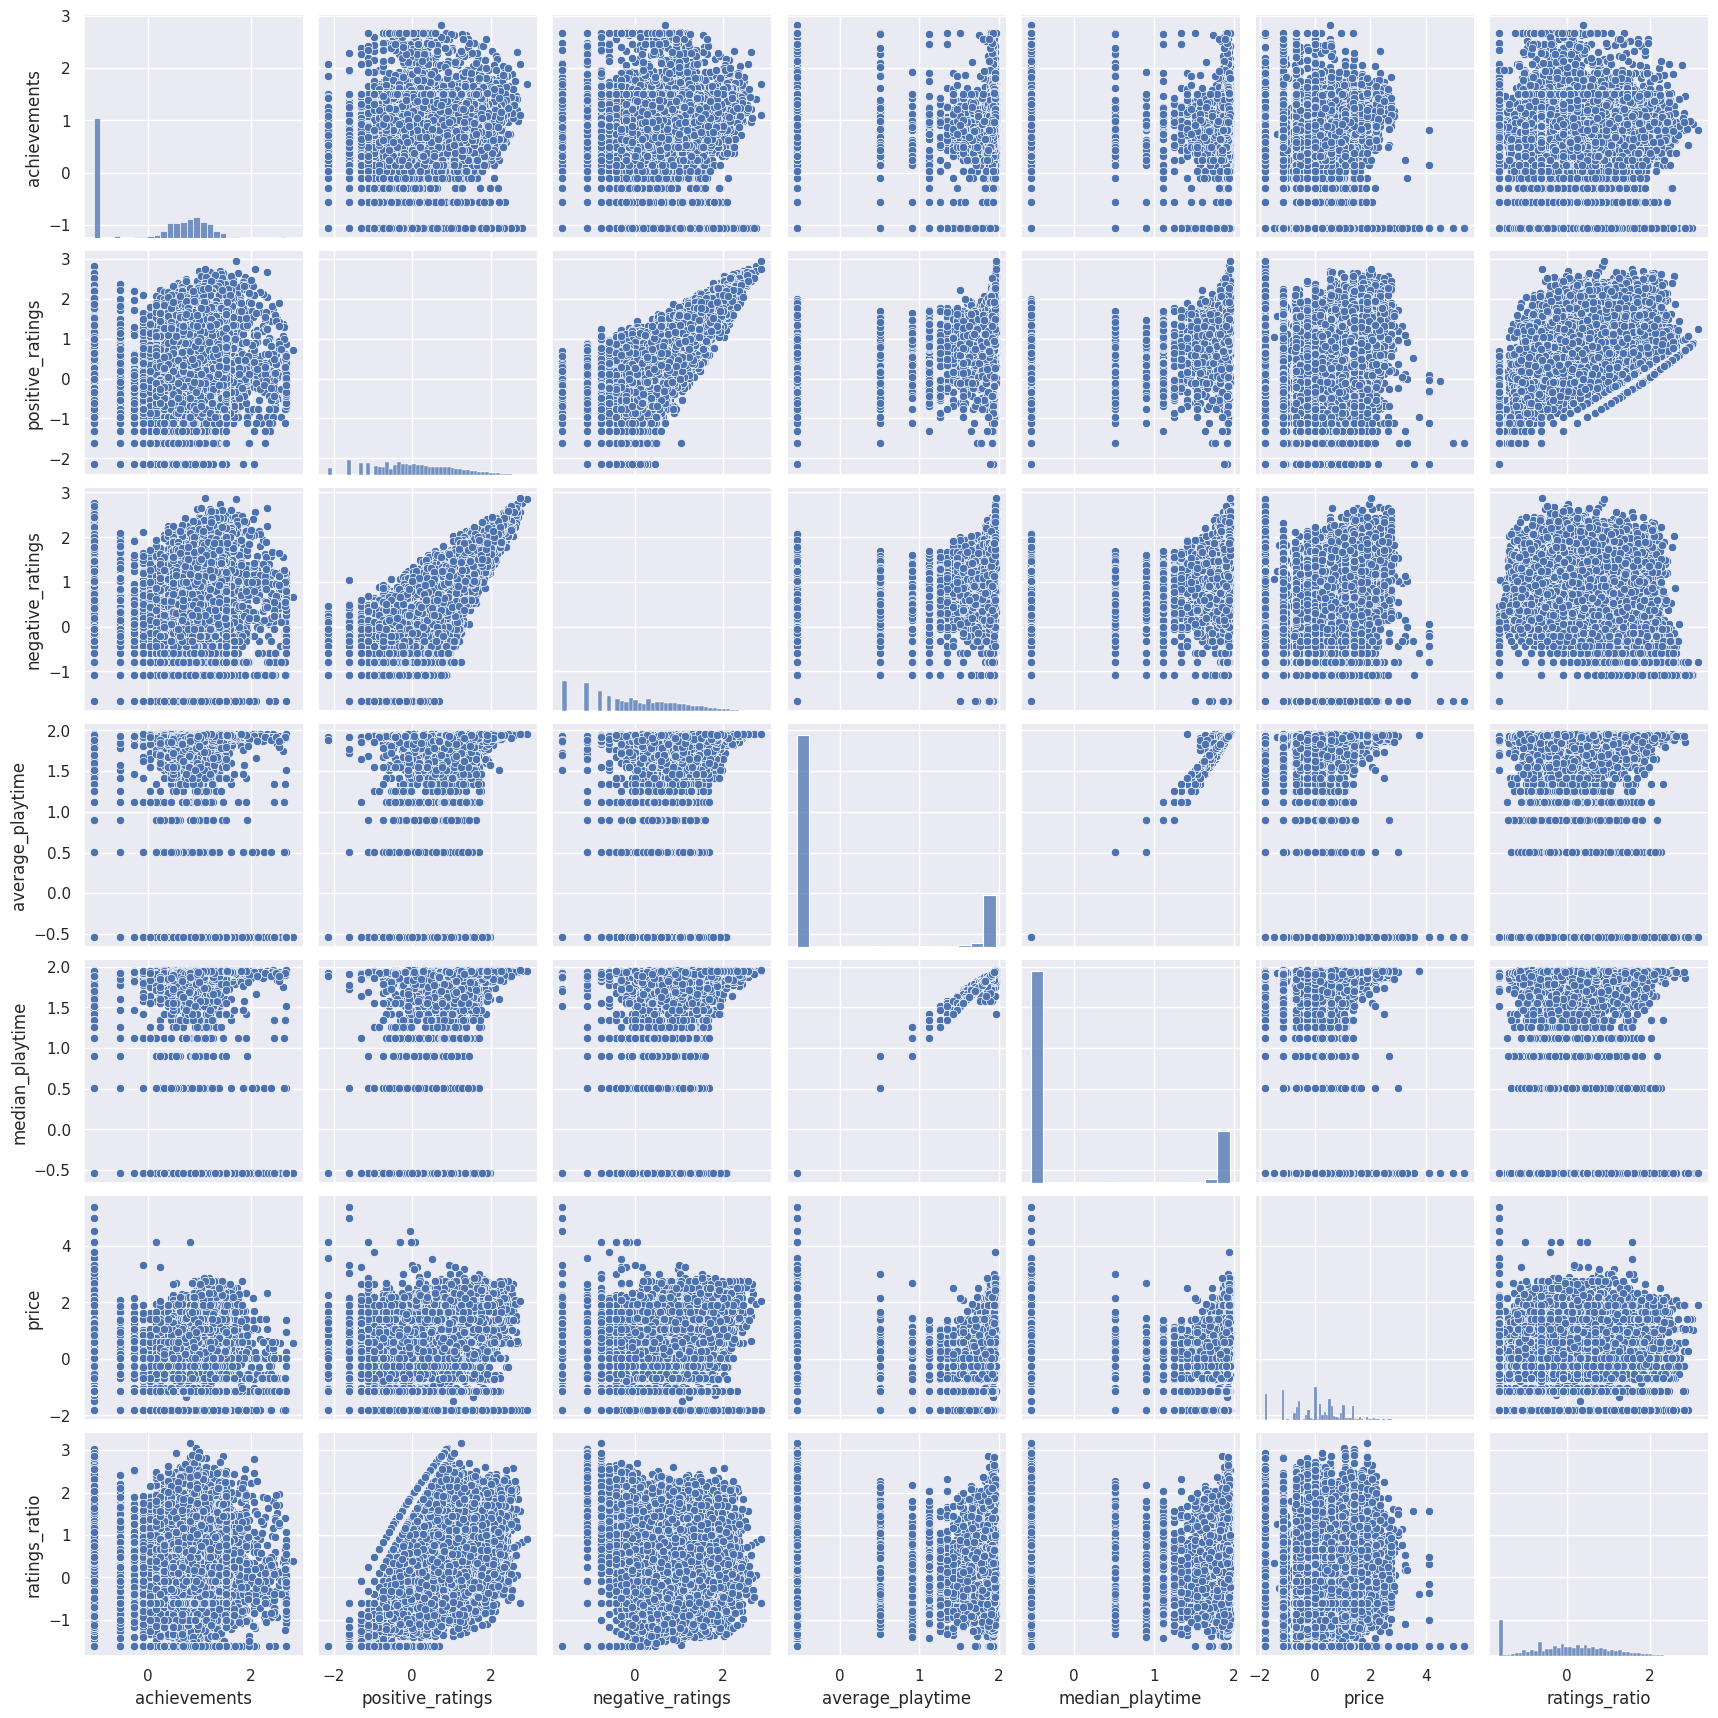

In [59]:
scaled = PowerTransformer().set_output(transform='pandas').fit_transform(kaggle_steam[columns])
sb.pairplot(scaled)

# PCA

In [60]:
acolumns = ['achievements', 'positive_ratings', 'negative_ratings', 'ratings_ratio', 'median_playtime', 'price']

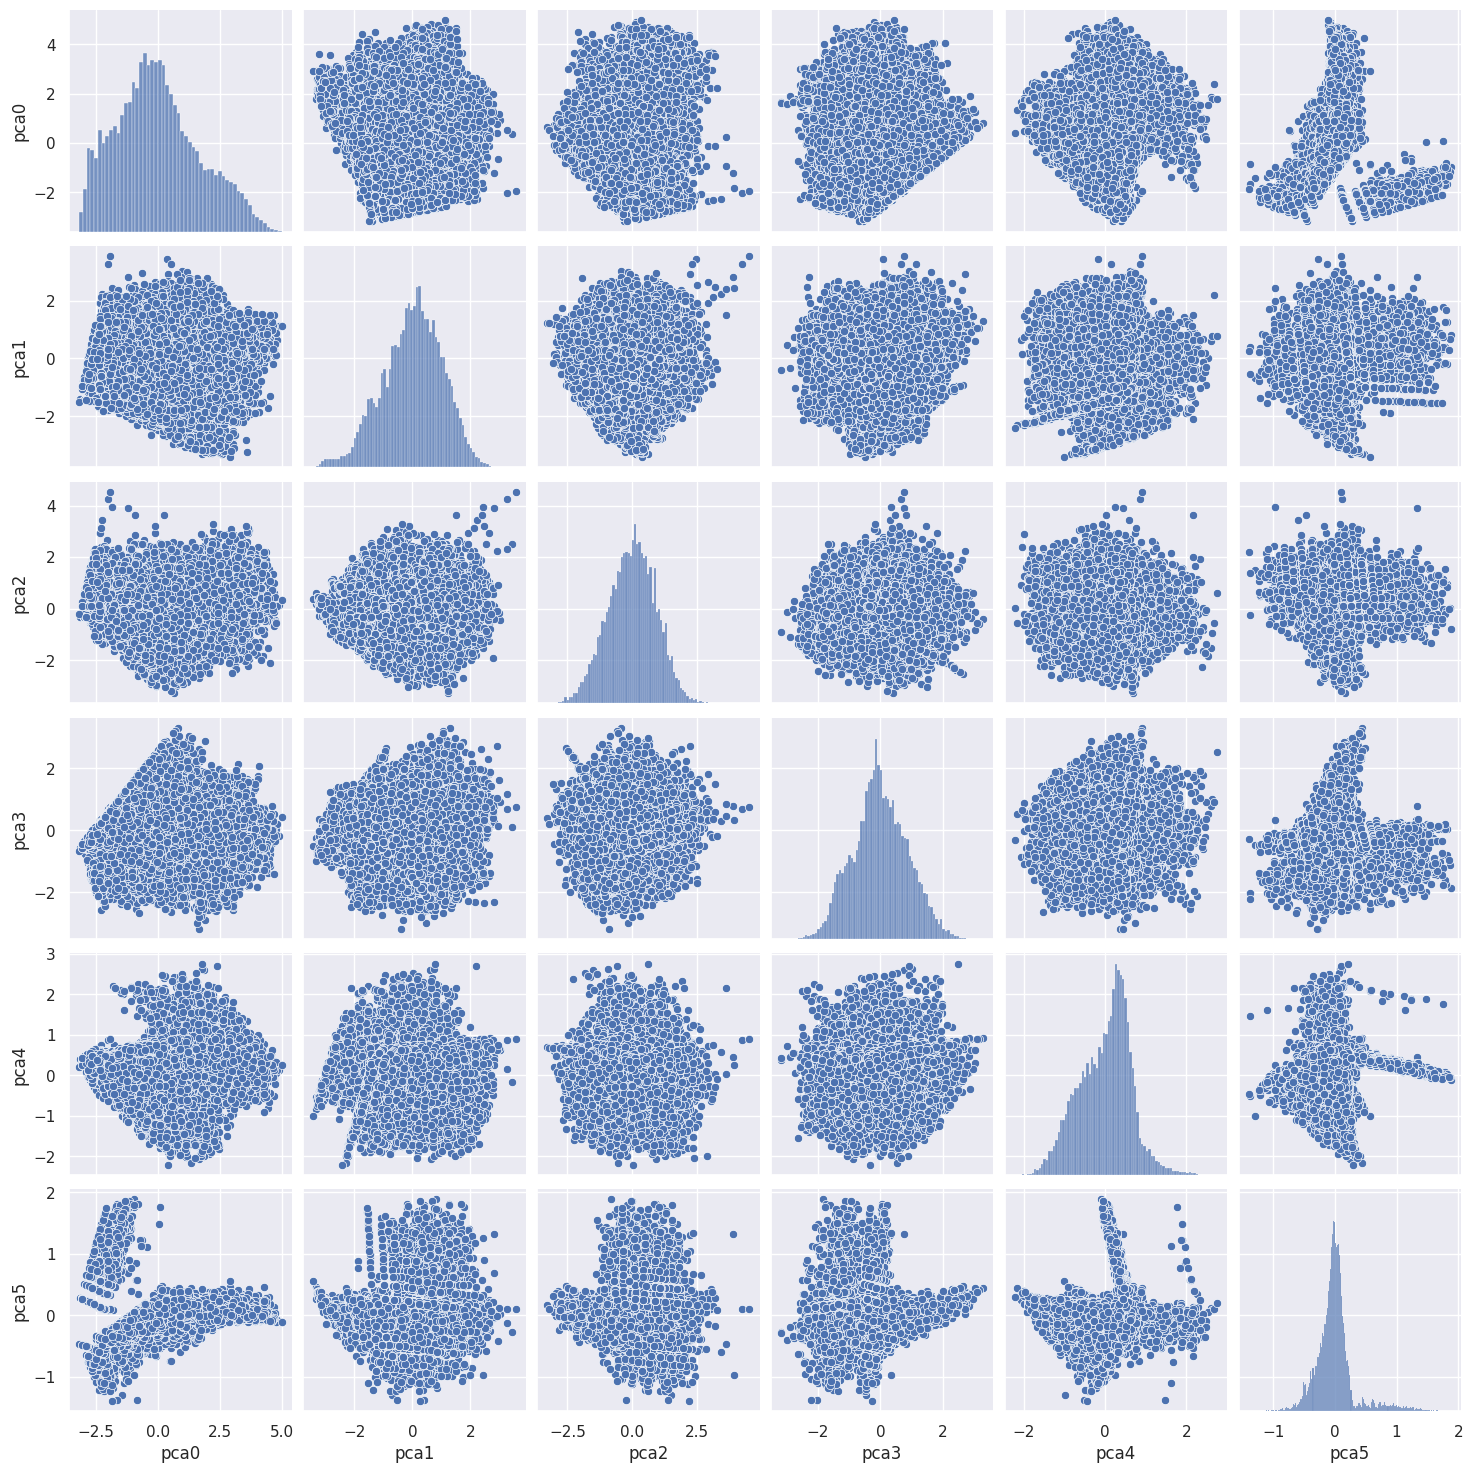

In [62]:
pca = PCA(n_components=6).set_output(transform='pandas').fit_transform(scaled[acolumns])
sb.pairplot(pca)

# Summary

In [64]:
keep = pd.concat([
    kaggle_steam[['appid'] + acolumns],
], axis=1)

catalog.save('features_eng_2', keep)

[04/18/23 02:06:29] INFO     Saving data to 'features_eng_2' (CSVDataSet)...                    ]8;id=679010;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=489171;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#382\382]8;;\